In [1]:
import sys
import pdb
import numpy as np
import qiskit as qk
import GPyOpt

from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator as wpo

sys.path.insert(0, '../core/')
from cost_weighted_ops import *
import utilities as ut

In [2]:
def ansatz(params):
    c = qk.QuantumCircuit(3)
    c.rx(params[0], 0)
    c.rx(params[1], 1)
    c.ry(params[2], 2)
    c.barrier()
    c.cnot(0,2) 
    c.cnot(1,2) 
    c.barrier()
    c.rx(params[3], 0)
    c.rx(params[4], 1)
    c.ry(params[5], 2)
    c.barrier()
    return c

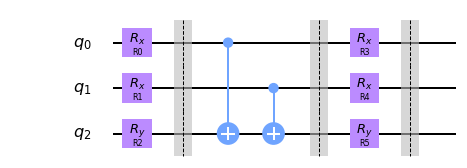

In [3]:
test_params = gen_params(6)
test_circ = ansatz(test_params)
test_circ.draw()

In [4]:
NB_SHOTS_DEFAULT = 256
OPTIMIZATION_LEVEL_DEFAULT = 3
# ===================
# Choose a backend using the custom backend manager and generate an instance
# ===================
bem = ut.BackendManager()
bem.get_current_status()
chosen_device = int(input('SELECT IBM DEVICE:'))
bem.get_backend(chosen_device, inplace=True)
inst = bem.gen_instance_from_current(nb_shots=NB_SHOTS_DEFAULT, 
                                     optim_lvl=OPTIMIZATION_LEVEL_DEFAULT)
inst_test = bem.gen_instance_from_current(nb_shots=8192, 
                                     optim_lvl=OPTIMIZATION_LEVEL_DEFAULT)

1 :    BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.0.6', operational=True, pending_jobs=5, status_msg='active')
2 :    BackendStatus(backend_name='ibmq_vigo', backend_version='1.0.2', operational=True, pending_jobs=69, status_msg='active')
3 :    BackendStatus(backend_name='qasm_simulator', backend_version='0.4.1', operational=True, pending_jobs=0, status_msg='')


SELECT IBM DEVICE: 3


Generated a new quantum instance
Generated a new quantum instance


In [5]:
ghz_ops = wpo([ 
    (1,Pauli.from_label('IZZ')),
    (1,Pauli.from_label('XXX')),
    (-1,Pauli.from_label('XYY')),
    (-1,Pauli.from_label('YXY')),
    (-1,Pauli.from_label('YYX')),
    (1,Pauli.from_label('ZIZ')),
    (1,Pauli.from_label('ZZI')),
])
ghz_fidelity = CostWeightedOps(ansatz=ansatz, instance = inst, operators=ghz_ops, nb_params=6)
ghz_fidelity_test = CostWeightedOps(ansatz=ansatz, instance = inst_test, operators=ghz_ops, nb_params=6)

(-0.6015625+0j)
(-0.59375+0j)
(-0.65625+0j)
(-0.4453125+0j)
(-0.25+0j)
(-0.7734375+0j)
(0.015625+0j)
(1.0625+0j)
(0.5546875+0j)
(-0.9609375+0j)
(1.234375+0j)
(1.28125+0j)
(-0.65625+0j)
(-1.1484375+0j)
(-0.328125+0j)
(-0.4140625+0j)
(-0.6484375+0j)
(1.1875+0j)
(-0.8515625+0j)
(-0.8984375+0j)
(-0.46875+0j)
(-1.1796875+0j)
(-0.90625+0j)
(-0.890625+0j)
(1.984375+0j)
(1.5390625+0j)
(0.703125+0j)
(-1.078125+0j)
(0.25+0j)
(-0.8125+0j)
start optim
(2.3046875+0j)
(0.71875+0j)
(1.3203125+0j)
(2.3828125+0j)
(2.0703125+0j)
(2.75+0j)
(5.296875+0j)
(2.3203125+0j)
(6.53125+0j)
(6.4765625+0j)
(4.125+0j)
(5.9609375+0j)
(5.203125+0j)
(6.2578125+0j)
(6.453125+0j)
(6.8671875+0j)
(6.65625+0j)
(5.7890625+0j)
(6.921875+0j)
(6.953125+0j)
(6.890625+0j)
(6.9140625+0j)
(6.96875+0j)
(6.984375+0j)
(6.9296875+0j)
(7+0j)
(7+0j)
(6.9921875+0j)
(6.9921875+0j)
(7+0j)
(6.990234375+0j)
(6.990478515625+0j)

Name : GP regression
Objective : -17.782055710554907
Number of Parameters : 3
Number of Optimization Parameters : 3


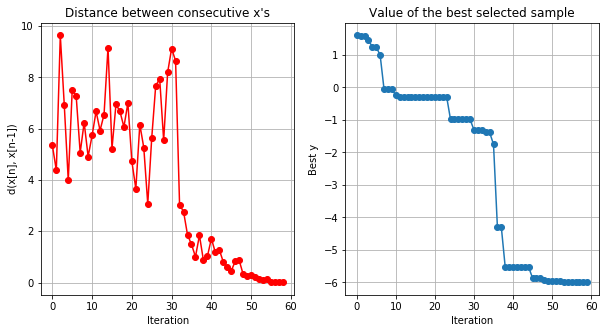

In [6]:
# ===================
# BO Optim
# No noise / Use of fidelity
# 20/25 works
#EPS = np.pi/2
#DOMAIN_RED = [(x-EPS, x+EPS) for x in X_SOL]
# ===================
# setup
NB_INIT = 30
NB_ITER = 30
X_SOL = np.pi/2 * np.array([[1.,1.,2.,1.,1.,1.]])
DOMAIN_FULL = [(0, 2*np.pi) for i in range(6)]
DOMAIN_BO = [{'name': str(i), 'type': 'continuous', 'domain': d} for i, d in enumerate(DOMAIN_FULL)]
bo_args = ut.gen_default_argsbo()
bo_args.update({'domain': DOMAIN_BO,'initial_design_numdata':NB_INIT})
cost_bo = lambda x: 1-ghz_fidelity(x) 

#optim
Bopt = GPyOpt.methods.BayesianOptimization(cost_bo, **bo_args)    
print("start optim")
Bopt.run_optimization(max_iter = NB_ITER, eps = 0)

# Results found
(x_seen, y_seen), (x_exp,y_exp) = Bopt.get_best()
ghz_fidelity_test(x_seen)
ghz_fidelity_test(x_exp)
print(Bopt.model.model)
Bopt.plot_convergence()